# **CONTROLLING METFORMIN**

<img src="https://raw.github.com/ModelEngineering/controlSBML/main/examples/images/simple_feedback_nofilter.png"
     alt="Markdown Monster icon" 
     width="600" height="750"
     style="float: left; margin-right: 10px;" />

This notebook explores the possibility of an external controller (e.g., an intelligent patch) to manage levels of metformin in the treatment of diabetes. The analysis develops a closed loop system using the model developed in "Physiologically based metformin pharmacokinetics model of mice and scale-up to humans for the estimation of concentrations in various tissues" by Darta Maija Zake, Janis Kurlovics, Linda Zaharenko, Vitalijs Komasilovs, Janis Klovins, Egils Stalidzans in PLOS ONE , 4/ 2021 , Volume 16 , Issue 4 , pages: e0249594 , DOI: 10.1371/journal.pone.0249594. The model developed in this paper are quite accurate in predicting metformin levels, as shown below. This is BioModels BIOMD0000001039.

<img src="https://raw.github.com/ModelEngineering/controlSBML/main/examples/images/metformin_overview.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

In [1]:
import numpy as np
try:
    import controlSBML as ctl
except:
    !pip install controlSBML
    import controlSBML as ctl
try:
    import control
except:
    !pip install control
    import control
#
from controlSBML import ControlSBML, constants
from controlSBML.grid import Grid
import matplotlib.pyplot as plt
from typing import Optional, List

# Helpers

In [2]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

## plotStep

In [3]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [4]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [5]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [6]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# Step 1. Design objectives

The biological problem we address is controlling metformin in the kidney, a key consideration since the only case where metformin is counterindicated for the treatment of diabetes is in the case of kidney disease. The idea is to explore the feasibility of an "intelligent patch" that would regulate the level of metformin in kidney tissue, possibly to better manage diabetes patients with kidney disease.
* Regulate metformin in kidney tissue
* Very fast settling times

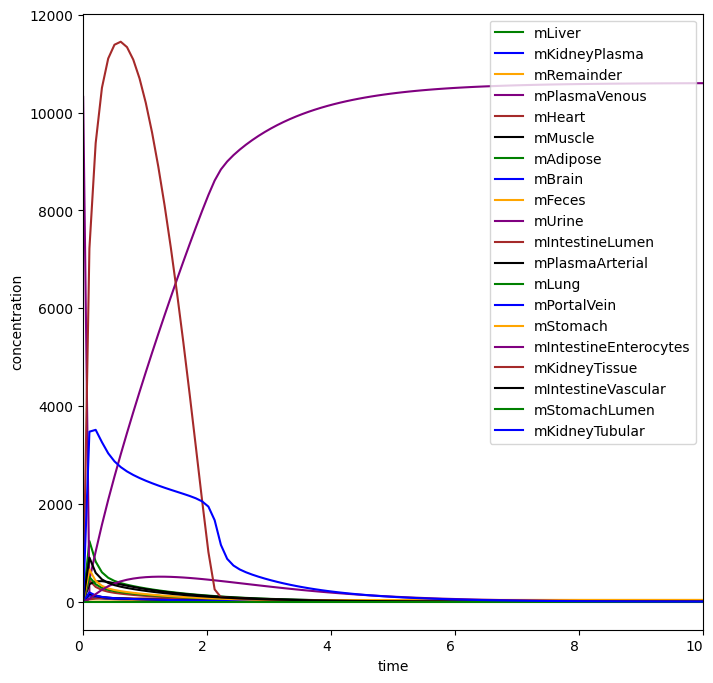

In [7]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
CTLSB = ControlSBML(URL)
_ = CTLSB.plotModel(figsize=(8,8))

# Step 2. Control input and operating region

We need an input that can be controlled by the intelligent patch. One candidate is arterial plasma, ``mPlasmaArterial``.

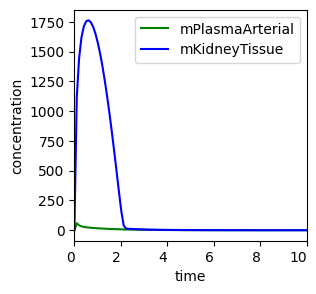

In [15]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
CTLSB = ControlSBML(URL)
_ = CTLSB.plotModel(selections=["mPlasmaArterial", "mKidneyTissue"], figsize=(3,3))

Now we need to specify the operating region of the system. This is a combination of the range of ``mPlasmaArterial`` we consider and the time constants involved. We do this by using a *staircase plot*. This is a series of steps of the input to evaluate the impact on the output. We are looking for several characteristics:
* Linearity. The output should be of consistent magnitude for constant step sizes of the input.
* Convergene. The output should converge within the during of a step.

In [30]:
INPUT_NAME = "mPlasmaArterial"
OUTPUT_NAME = "mKidneyTissue"
CTLSB = ControlSBML(URL, figsize=(5, 5), times=np.linspace(0, 2000, 20000), markers=False,
                   input_name=INPUT_NAME, output_name=OUTPUT_NAME)  # Specify default value of options

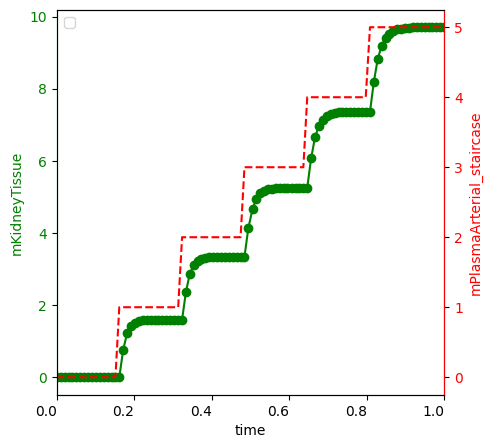

In [71]:
staircase_result = CTLSB.plotStaircaseResponse(initial_value=0, final_value=5, num_step=5,
    times=np.linspace(0, 1, 100))

In [163]:
staircase_result.antimony_builder

// Created by libAntimony v2.13.2
function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function Glomerular(S, Flow)
  S*Flow;
end

Glomerular is "Glomerular"

function Flow(Q, S)
  Q*S;
end

Flow is "Flow"

function Flow_from_organ(Q, S, Ktp)
  Q*S/Ktp;
end

Flow_from_organ is "Flow from organ"


model *Zake2021___PBPK_model_of_metformin_in_mice__single_dose_intavenous()

  // Compartments and Species:
  compartment IntestineLumen, Liver, KidneyPlasma, Remainder, PlasmaVenous;
  compartment Urine, Feces, Heart, Muscle, Brain, Adipose, PlasmaArterial;
  compartment Lung, PortalVein, Stomach, IntestineEnterocytes, KidneyTissue;
  compartment IntestineVascular, StomachLumen, KidneyTubular;
  substanceOnly species mLiver in Liver, mKidneyPlasma in KidneyPlasma, mRemainder in Remainder;
  substanceOnly species mPlasmaVenous in PlasmaVenous, mHeart in Heart, mMuscl

# Step 3. System identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is mPlasmaArterial and the output is mKidneyTissue. mPlasmaArterial is varied over the operating region of [0, 5]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns an object with several properties of interest: Timeseries (a dataframe with the data plotted) and AntimonyBuilder (the Antimony code run to produce the fitting data).

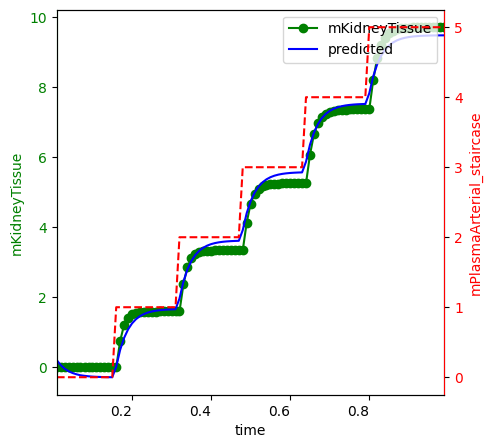

In [166]:
fit_result = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2, initial_value=0,
        final_value=5, times=np.linspace(0, 1, 100))

The ``getOpenLoopTransferFunction`` method gets the transfer function for the fit. This is a ``control.TransferFunction`` object and so can be used with the many analysis capabilities of the Python Control Systems Libary package.

In [105]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([267.14144611,   3.78228102]), array([  3.95596418, 136.85793539,   2.05606907]))

In [106]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-3.45803125e+01+0.j, -1.50299119e-02+0.j]), array([-0.01415835+0.j]))

# Step 4. Theory-based design

In the open loop, there is a zero, -0.014, that is very close to a pole, -0.015. This suggests that the influence of the pole at -0.015 will be quite small. So, we likely should use a transfer function with the single pole at -34.58.

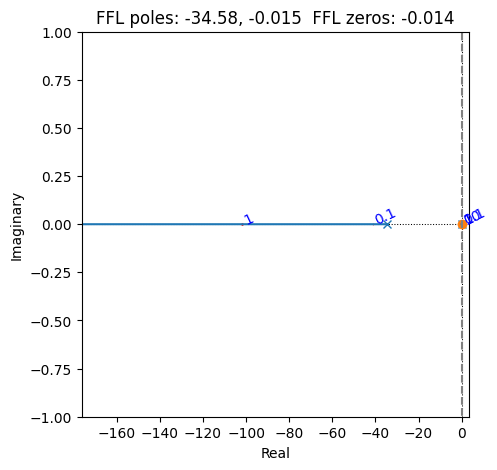

In [168]:
_ = plotRootLocusWithGains(TRANSFER_FUNCTION, [0.1, 1, 10], markersize_multiplier=1)

We see a branch that starts at -34.58 and moves let. However, we also see a branch that starts at -0.015 and moves to -0.014. There's not much we can do with this. However, the close proximity of the pole and zero suggests that there likely is a large amount of pole-zero cancelation, and so the effect of this branch will be small.

Given this, we focus on the branch that moves left from -34.48. To avoid having an excessively large $k_P$, we consider PI-control.

In [153]:
REVISED_TRANSFER_FUNCTION = control.zpk([], [-34.58], TRANSFER_FUNCTION.dcgain())
REVISED_TRANSFER_FUNCTION

TransferFunction(array([1.83956904]), array([ 1.  , 34.58]))

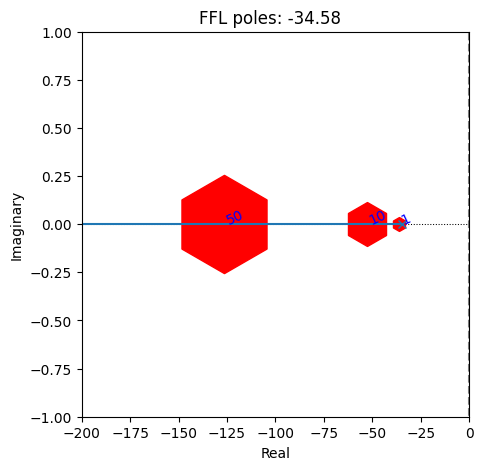

In [157]:
_ = plotRootLocusWithGains(REVISED_TRANSFER_FUNCTION, [1, 10, 50], xlim=[-200, 0])

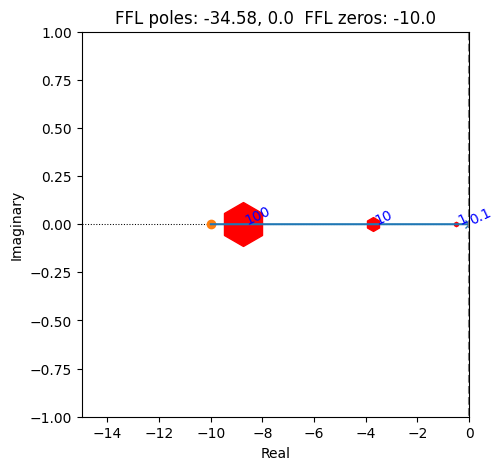

In [160]:
rIP = 10
controller_tf = control.TransferFunction([1, rIP], [1, 0]) 
_ = plotRootLocusWithGains(REVISED_TRANSFER_FUNCTION*controller_tf, [0.1, 1, 10, 100], markersize_multiplier=10, xlim=[-15, 0])

# Step 5. Testbed-based design

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' wh

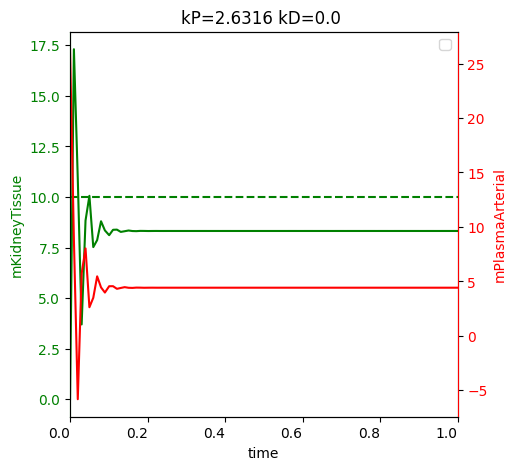

In [172]:
grid = Grid()
grid.addAxis("kP", min_value=0, max_value=50, num_coordinate=20)
#grid.addAxis("kI", min_value=0.000, max_value=100, num_coordinate=20)
grid.addAxis("kD", min_value=0.000, max_value=0.1, num_coordinate=10)
_ = CTLSB.plotGridDesign(grid, setpoint=10, times=np.linspace(0, 1, 100))

1. The theory-based design provides a starting point for your final design. It fast settling time suggests that pole-zero cancelation is a reasonable assumption. However, we see oscillations in the early part of the response. This suggests some inaccuracy in our system identification since no oscillations are indicated in the root locus plot.